## Motif Conversion

In [4]:
import os
from Bio.motifs import parse
import tqdm

In [5]:
def convert_jaspar_to_moods_pfm(jaspar_file, outdir):

    with open(jaspar_file, 'r') as f:
        motifs = parse(f, 'jaspar')
        
    for motif in tqdm.tqdm(motifs, desc = 'Converting motifs'):

        #if not motif.name is None and not motif.matrix_id is None:
        factor_name = motif.name.upper()
        motif_id = motif.matrix_id
        #else:
        #    factor_name, motif_id = os.path.basename(jaspar_file).replace('.jaspar','').replace('/','-')\
        #        .upper().split('_')

        new_motif_filename = os.path.join(outdir, '{}_{}.{}'.format(
                motif_id, factor_name.replace('(','.').replace(')', ''), 'jaspar'
            ).replace('/', '-'))

        with open(new_motif_filename, 'w') as f:
            for nuc in ['A','C','G','T']:
                print(*list(map(int, motif.counts[nuc])), sep = '\t', file = f)
                
convert_jaspar_to_moods_pfm('data/jasparmotifs.jaspar', 'data/newmotifs/')

Converting motifs: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 838/838 [00:00<00:00, 3492.24it/s]


In [758]:
import mira
import anndata
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
mira.utils.wide_view()

### QC

with open('data/neuroendocrine/peaks/diffpeaks_aggr_day6_distances.txt','r') as f:
    d = np.array([int(x.strip()) for x in f])

sns.displot(np.log10(d))

### Server data

!mkdir data/neuroendocrine/2021-12-24_models/

!scp alynch@cistrome.org:/liulab/alynch/projects/multiomics/endocrine/MIRA/data/retraining/* ./data/neuroendocrine/2021-12-24_models/

### Load models

In [2]:
!realpath /Users/alynch/Dropbox\ \(Partners\ HealthCare\)/Data/neuroendocrine/2021-12-10_best_rna_model.pth

/Users/alynch/Dropbox (Partners HealthCare)/Data/neuroendocrine/2021-12-10_best_rna_model.pth


In [8]:
rna_model = mira.topics.ExpressionTopicModel.load('data/neuroendocrine/2021-12-24_models/2021-12-24_best_rna_model.pth')
atac_model = mira.topics.AccessibilityTopicModel.load('data/neuroendocrine/2021-12-24_models/2021-12-24_best_atac_model.pth')

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


### Load data

In [9]:
#rna_data = anndata.read_h5ad('data/neuroendocrine/2021-12-24_models/rna_data.h5ad')
atac_data = anndata.read_h5ad('data/neuroendocrine/2021-12-24_models/atac_data.h5ad')

In [6]:
rna_model.get_learning_rate_bounds(rna_data)

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: exog
INFO:mira.adata_interface.topic_model:Using highly-variable genes from col: endog
Learning rate range test: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 171/171 [01:06<00:00,  2.55it/s]
INFO:mira.topic_model.base:Set learning rates to: (5.4853542473304e-06, 0.14028935652777344)


(5.4853542473304e-06, 0.14028935652777344)

INFO:mira.topic_model.base:Set learning rates to: (0.0036485374818961687, 0.08508979596545126)


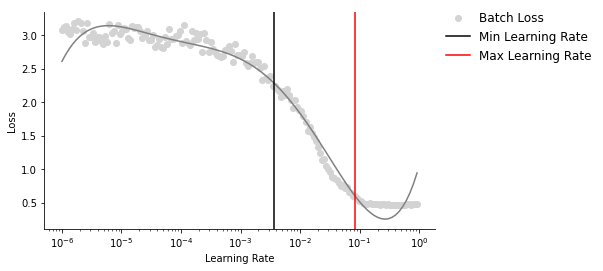

In [15]:
rna_model.trim_learning_rate_bounds(6.5,1)
rna_model.plot_learning_rate_bounds(figsize=(7,4))
plt.savefig('sphinxdocs/source/_static/mira.topics.plot_learning_rate_bounds.svg')

### Joint representation

In [16]:
rna_model.counts_layer = 'counts'

In [26]:
rna_data = anndata.read_h5ad('/Users/alynch/Dropbox (Partners HealthCare)/shareseq_code_ocean/hair_follicle.h5ad')

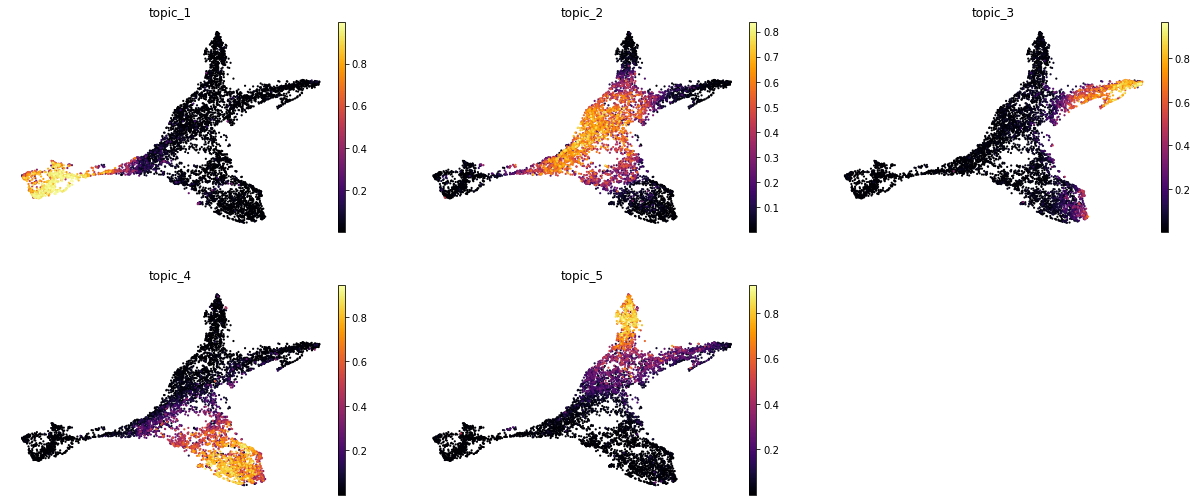

In [28]:
sc.pl.umap(rna_data, color = ['topic_' + str(i) for i in [9,6,10,4,5]], **mira.pref.topic_umap(ncols=3),
          title = ['topic_' + i for i in ['1','2','3','4','5','6']], show = False)
plt.savefig('sphinxdocs/source/_static/mira.topics.predict.png')

In [23]:
rna_model.predict(rna_data)

Predicting latent vars: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:03<00:00,  9.41it/s]
INFO:mira.adata_interface.topic_model:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28


In [25]:
rna_model.get_umap_features(rna_data)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


In [7]:
atac_model.predict(atac_data)

Predicting latent vars: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:59<00:00,  1.65s/it]
INFO:mira.adata_interface.topic_model:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10


In [28]:
atac_model.get_hierarchical_umap_features(atac_data, box_cox=0.5)
rna_model.get_hierarchical_umap_features(rna_data, box_cox=0.5)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram


In [29]:
rna_data, atac_data = mira.utils.make_joint_representation(rna_data, atac_data)

INFO:mira.adata_interface.utils:18333 out of 18333 cells shared between datasets (100%).
INFO:mira.adata_interface.utils:Key added to obsm: X_joint_umap_features


In [30]:
rna_data.obsm['X_joint_topic_compositions'] = np.hstack([rna_data.obsm['X_topic_compositions'], atac_data.obsm['X_topic_compositions']])

In [31]:
sc.pp.neighbors(rna_data, use_rep = 'X_joint_umap_features', metric = 'manhattan')
sc.tl.umap(rna_data, min_dist = 0.1, negative_sample_rate=1)

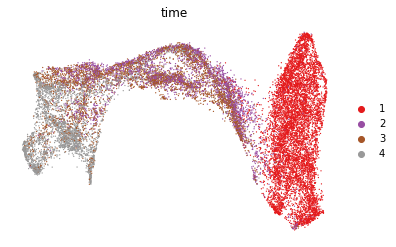

In [32]:
sc.pl.umap(rna_data, frameon = False, color = 'time', palette = 'Set1')

### Pseudotime

In [1]:
import mira
import anndata
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
mira.utils.wide_view()

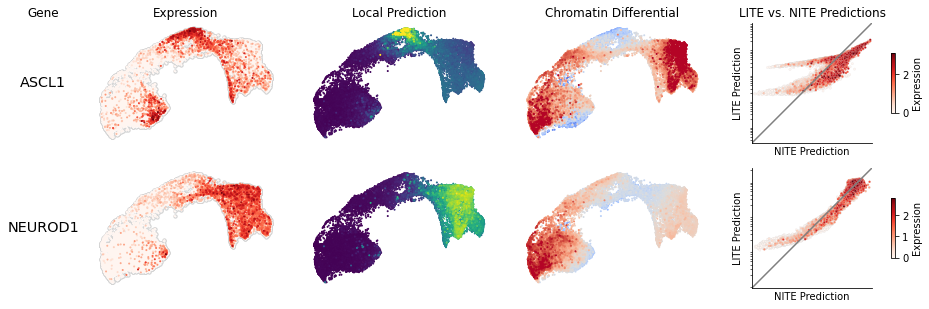

In [2]:
rna_data = anndata.read_h5ad('data/analysis/ascl1_rna_data.h5ad')
mira.pl.plot_chromatin_differential(rna_data, genes = ['ASCL1','NEUROD1'], height = 2.2, add_legend = False, aspect=1.4)
plt.show()

In [775]:
rna_data = anndata.read_h5ad('data/neuroendocrine/2021-12-24_models/2021-12-27_rna_data_with_pseudotime.h5ad')
#atac_data = anndata.read_h5ad('data/neuroendocrine/2021-12-24_models/atac_data.h5ad')

In [239]:
sc.tl.diffmap(rna_data)
mira.time.normalize_diffmap(rna_data, rescale=True)

INFO:root:Added key to obsm: X_diffmap, normalized diffmap with 14 components.
INFO:root:Added key to uns: eigen_gap


Recommending 2 diffusion map components.


/Users/alynch/projects/multiomics/mira/mira/mira/plots/eigengap_plot.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  ax[0].plot(range(len(eigvals)-1), eigvals[1:], '--bo', c = 'black')


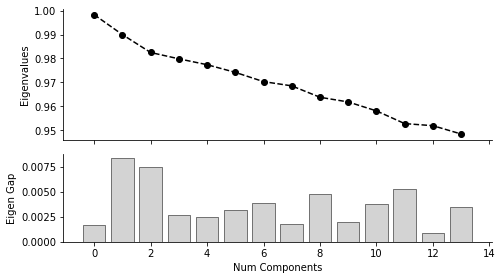

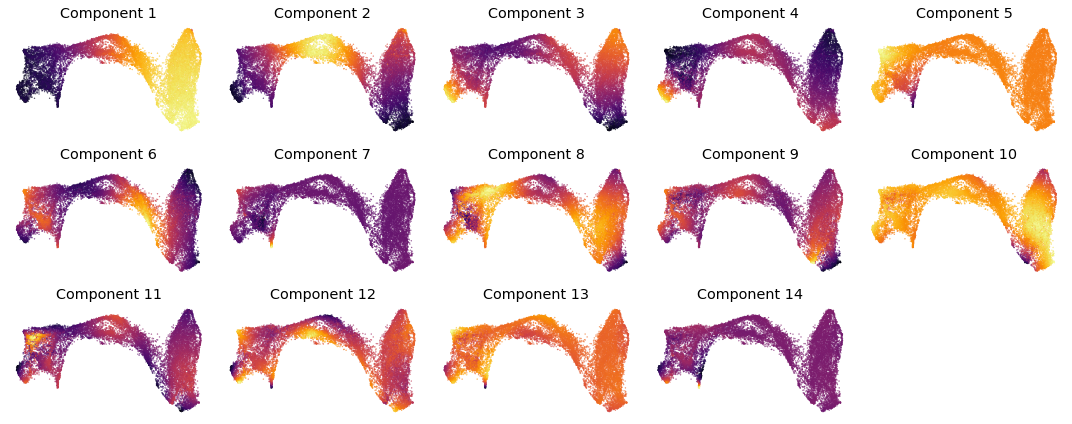

In [240]:
mira.pl.plot_eigengap(rna_data, size=0.1, palette='inferno')
plt.show()

In [241]:
sc.pp.neighbors(rna_data, use_rep='X_diffmap', key_added='X_diffmap', n_neighbors = 30, n_pcs = 6)
mira.time.get_connected_components(rna_data)

INFO:mira.pseudotime.pseudotime:Found 1 components of KNN graph.
INFO:mira.adata_interface.core:Added cols to obs: mira_connected_components


In [242]:
mira.time.get_transport_map(rna_data, start_cell=int(rna_data.obsm['X_diffmap'][:,0].argmax()),
                           n_jobs = 5, ka = 5)

INFO:mira.pseudotime.pseudotime:Calculating inter-cell distances ...
Calculating pseudotime:   4%|███████████▊                                                                                                                                                                                                                                                                                          | 2574/64350 [00:01<00:31, 1936.33it/s]
INFO:mira.pseudotime.pseudotime:Calculating transport map ...
INFO:mira.adata_interface.pseudotime:Added key to obs: mira_pseudotime
INFO:mira.adata_interface.pseudotime:Added key to obsp: transport_map
INFO:mira.adata_interface.pseudotime:Added key to uns: start_cell


In [243]:
terminal_cells = mira.time.find_terminal_cells(rna_data)

INFO:mira.pseudotime.pseudotime:Found 3 terminal states from stationary distribution.


In [244]:
terminal_states = dict(zip('ABCD',['AGTGATGAGTTGTCTT-3', 'AATGCGCGTTTCCGGC-4', 'ATCAATCCATGTTGCA-4',
       'GGTCAAGCACCTACTT-4']))

/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'mira_connected_components' as categorical


<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

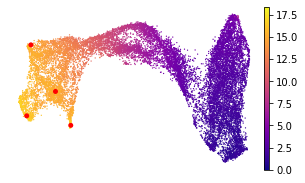

In [245]:
fig,ax=plt.subplots(1,1,figsize=(5,3))
sc.pl.umap(rna_data,ax=ax,show = False, color= 'mira_pseudotime', color_map = 'plasma',)
sc.pl.umap(rna_data[list(terminal_states.values())], ax=ax, show = False, na_color = 'Red', size = 100, frameon=False)
#sc.pl.umap(rna_data[terminal_cells], ax=ax, show = False, na_color = 'Red', size = 100, frameon=False)

In [246]:
mira.time.get_branch_probabilities(rna_data, terminal_cells=terminal_states)

INFO:mira.pseudotime.pseudotime:Simulating random walks ...
INFO:mira.adata_interface.pseudotime:Added key to obsm: branch_probs
INFO:mira.adata_interface.pseudotime:Added key to uns: lineage_names
INFO:mira.adata_interface.core:Added cols to obs: A_prob
INFO:mira.adata_interface.core:Added cols to obs: B_prob
INFO:mira.adata_interface.core:Added cols to obs: C_prob
INFO:mira.adata_interface.core:Added cols to obs: D_prob
INFO:mira.adata_interface.core:Added cols to obs: differentiation_entropy


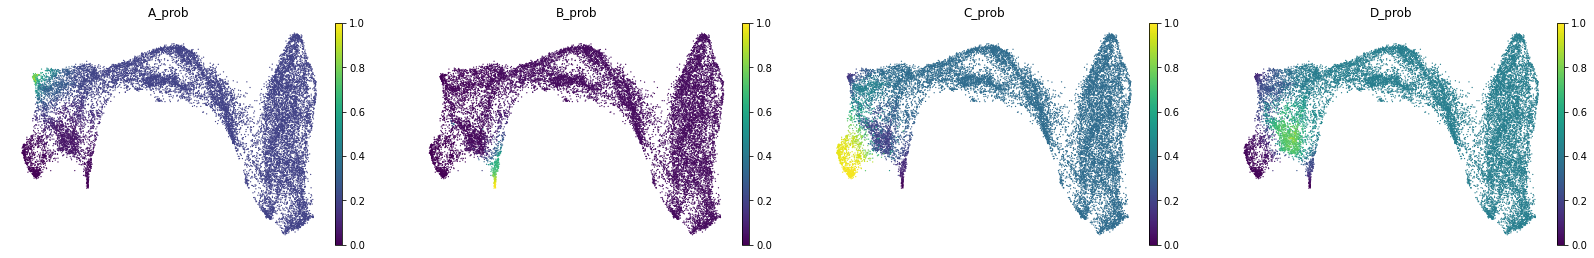

In [247]:
sc.pl.umap(rna_data, color = [x+'_prob' for x in rna_data.uns['lineage_names']], palette = 'plasma', frameon = False)

INFO:mira.adata_interface.pseudotime:Added key to obs: tree_states
INFO:mira.adata_interface.pseudotime:Added key to uns: tree_state_names
INFO:mira.adata_interface.pseudotime:Added key to uns: connectivities_tree
/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tree_states' as categorical


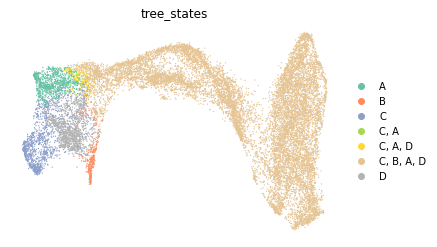

In [248]:
mira.time.get_tree_structure(rna_data, threshold=0.5)
sc.pl.umap(rna_data, color = 'tree_states', palette = 'Set2', frameon = False)

rna_data.obs['adj_time'] = np.log10(np.log10(rna_data.obs.mira_pseudotime+1)+1)

mira.pl.plot_stream(rna_data, style = 'swarm', max_swarm_density=100, size = 2, data = ['GHRL'], log_pseudotime=False,
                   palette='Reds', linecolor='grey', layers = 'normalized')

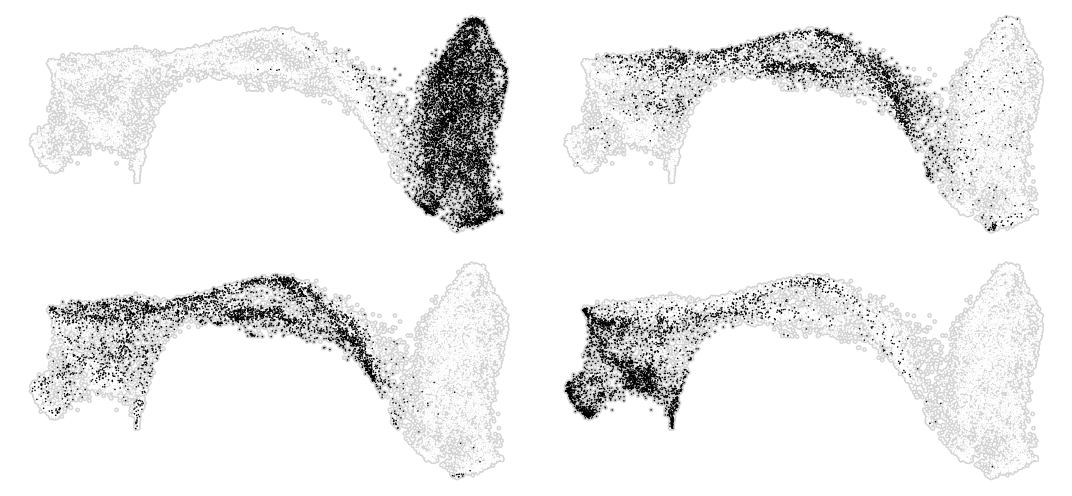

In [249]:
fig, ax = plt.subplots(2,2, figsize=(15,7))
for i, t in enumerate(rna_data.obs.time.unique()):
    sc.pl.umap(rna_data, na_color = 'white', frameon=False, ax = ax[i//2, i%2], show = False,
               add_outline=True, outline_color=('lightgrey','white'), outline_width=(1,0),size=10)
    
    sc.pl.umap(rna_data[rna_data.obs.time == t], na_color = 'black', frameon=False, ax = ax[i//2, i%2], 
               show = False, size = 10)
    
plt.tight_layout()

sc.pl.umap(rna_data, color = rna_model.topic_cols, **mira.pref.topic_umap(color_map='plasma_r'), vmin = -0.1)

atac_data.obsm['X_umap'] = rna_data.obsm['X_umap']

sc.pl.umap(atac_data, color = atac_model.topic_cols, **mira.pref.topic_umap(color_map='viridis_r'), vmin = -0.1)

rna_data.write_h5ad('data/neuroendocrine/checkpoint_rna_data.h5ad')
atac_data.write_h5ad('data/neuroendocrine/checkpoint_atac_data.h5ad')

rna_data = anndata.read_h5ad('data/neuroendocrine/checkpoint_rna_data.h5ad')

atac_data.var[['chr','start','end']] = list(map(list, atac_data.var.index.str.split(':|-').values))

tss_data= pd.read_csv('/Users/alynch/genomes/hg38/hg38_cannonical_TSS.tsv', sep = '\t').dropna().drop_duplicates(subset = 'hg38.kgXref.geneSymbol')
tss_data.columns = tss_data.columns.str.split('.').str.get(-1)
tss_data = tss_data.iloc[:,1:]
tss_data = tss_data[tss_data.chrom.isin(np.unique(atac_data.var.chr.values))]

tss_data.to_csv('/Users/alynch/genomes/hg38/hg38_cannonical_TSS_normalized.tsv', sep = '\t')

!scp /Users/alynch/genomes/hg38/hg38_cannonical_TSS_normalized.tsv alynch@cistrome.org:/liulab/alynch/projects/multiomics/endocrine/MIRA/data/

!scp /Users/alynch/genomes/hg38/hg38.genome alynch@cistrome.org:/liulab/alynch/projects/multiomics/endocrine/MIRA/data/

mira.tl.get_distance_to_TSS(atac_data, 
                            tss_data = tss_data, 
                            gene_chrom='chrom', 
                            gene_strand='strand', 
                            gene_start='chromStart',
                            gene_end='chromEnd',
                            genome_file = '/Users/alynch/genomes/hg38/hg38.genome'
                           )

In [2]:
rna_data = anndata.read_h5ad('data/neuroendocrine/rna_data.h5ad')

sc.tl.umap(rna_data, min_dist=0.1, negative_sample_rate=1, n_components=3)

def umap_3d(X, hue, palette = 'viridis', size = 1, figsize = (12,8), hue_order = None,
           vmin = None):
    
    try:
        import plotly.graph_objects as go
    except ImportError:
        raise Exception('Must install plotly to use this feature. Run conda install plotly or pip install plotly.')

    color = map_colors(None, hue, palette, add_legend=False, hue_order = hue_order,
                      vmin = vmin)

    if X.shape[-1] == 2:
        z_dim = np.zeros(len(X))
    else:
        z_dim = X[:,2]

    fig = go.Figure(data=[go.Scatter3d(
        x=X[:,0],
        y=X[:,1],
        z=z_dim,
        mode='markers',
        marker=dict(
            size=size,
            color = color,
            opacity=0.8
        ),
        hovertext=np.arange(len(X))
    )])

    fig.update_layout(scene=dict(xaxis = dict(showgrid=False, showticklabels = False, backgroundcolor="white", visible = False), 
                                yaxis = dict(showgrid=False, showticklabels = False, backgroundcolor="white", visible = False), 
                                zaxis = dict(showgrid = False, showticklabels = False, backgroundcolor="white", visible = False)),
                    width=figsize[0]*100, height=figsize[1]*100,
                    margin=dict(
                        r=0, l=0,
                        b=0, t=0)
                    )
    fig.show()
    return fig

_ = umap_3d(rna_data[rna_data.obs.time == 'PS6'].obsm['X_umap'], rna_data[rna_data.obs.time == 'PS6'].obs_vector('topic_3'), palette='plasma_r', vmin = -0.1,
           size = 2)

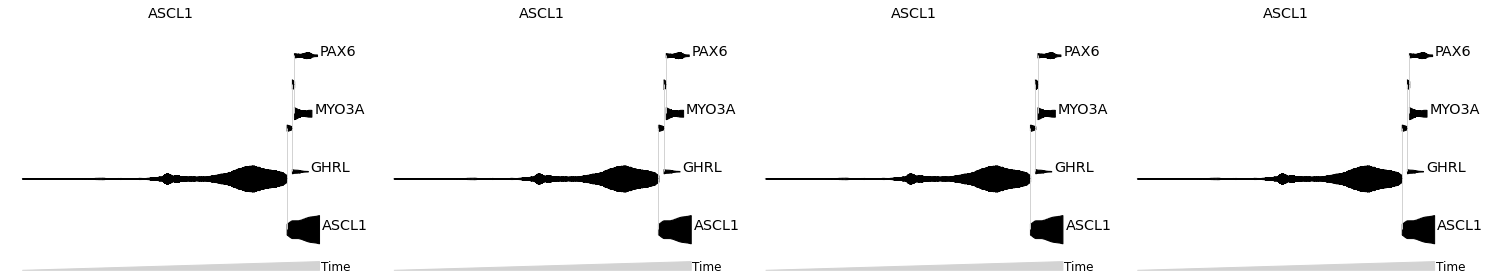

In [7]:
mira.pl.plot_stream(rna_data, data = ['ASCL1']*4, max_bar_height=0.8, layers = 'normalized',
                   split = True, clip = 2, window_size=501)
plt.show()